In [1]:
#Install Required Libraries
#!pip install PyPDF2 spacy pandas numpy matplotlib seaborn scikit-learn sentence-transformers pytesseract pdf2image

# Install the SpaCy model
#!python -m spacy download en_core_web_sm
#!pip install wordcloud nltk

# Download WordNet data
#import nltk
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#!pip install -U sentence-transformers
#!pip install shap

In [22]:
import numpy as np
import pandas as pd
import os
import PyPDF2
import pytesseract
import re
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import shap
import torch
from transformers import BertTokenizer, BertModel



### 1. Data Cleaning and Preparation

In [3]:
# Load metadata
metadata = pd.read_csv('/workspaces/project-2-ombudsman/metadata.csv')

# Set the directories
base_folders = [
    #'/workspaces/project-2-ombudsman/12_23_insurance',
    #'/workspaces/project-2-ombudsman/01_24_insurance',
    #'/workspaces/project-2-ombudsman/02_24_insurance',
    #'/workspaces/project-2-ombudsman/03_24_insurance',
    #'/workspaces/project-2-ombudsman/04_24_insurance',
    '/workspaces/project-2-ombudsman/05_24_insurance'
]

# Load spaCy model
nlp = spacy.load("en_core_web_sm")


In [4]:
# Function to get metadata info
def get_metadata_info(filename):
    decision_id = re.search(r'DRN-(\d+)', filename).group(1)
    row = metadata[metadata['decision_id'].str.contains(decision_id)]
    if not row.empty:
        decision = row.iloc[0]['decision']
        company = row.iloc[0]['company']
        return decision, company
    else:
        return None, None

**Exclude words**

# Expanded custom stop words list
text_exclude = set([
    "aa", "d", "g",
    "able", "account", "act", "action", "accept", "add", "address", "after","agree", "appear", "appeared", "apply", 
    "appreciate", "april", "august", "arrange", "are", "ask", "august", "available", 
    "base", "basis", "be", "been", "before", "begin", "believe", "behalf", "buy",
    "can", "case", "carry", "cause", "claim", "complain", "complains", "complaint", "complained","comment", "company", 
    "conclude", "conclusion", "concern", "consider", "continue", "could", "cost", "customer",
    "date", "day", "decide", "decision","decrease", "deduct", "december", "discuss", "direct", "does", "did", 
    "europe","event", "evidence","explain", "example", "existing", "end",
    "feel", "felt", "february", "final", "find", "finding", "first", "follow", "fully",
    "gave", "get", "give", "go", "going", "got", 
    "handle", "happen", "happened", "had", "has", "have", "hm","hours", "how", 
    "incident", "include", "increase", "indicate","initial", "insurance", "investigate", "investigator", "i.e.", "is", "issue", "item", 
    "january", "july", "june", "know", "knew", "later", "lead", "list", "like", "line", "likely", "limited", "Limited", "ltd", "Ltd", "look", "looked", 
    "main", "make", "made", "march", "matter", "may", "mean", "might", "minutes", "month", 
    "need", "new", "not uphold", "note", "november", "number", "october", "ombudsman", "overall",
    "ph", "photo", "perhaps", "policy", "place", "point", "position", "pre", "previous","prior", "provisional", "provide", "put", "question", 
    "reason", "receive", "record", "refer", "remain", "report", "request", "require", "result", "return", "right", 
    "sa","said", "saw", "say", "see", "second", "section", "seen", "send", "set", "september", 
    "shall", "should", "show", "simple","sorry","start", "summary", "sun",
    "take", "tell", "the", "third","thing", "think", "thought", "time", "to", "told", "total", "took", "turn", "try",
    "uk","uphold","unable",  "use", "usually", "ultimately","vitality",
    "want", "way", "was", "went", "were", "week",
    "what", "when", "where", "which", "whilst", "why", "will", "work", "would", 
    "year"
])

In [127]:
# Function to get synonyms from WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for l in syn.lemmas():
            synonyms.add(l.name().replace('_', ' ').lower())
    return synonyms

# Function to create synonym mapping for a list of words
def create_synonym_mapping(words):
    mapping = {}
    for word in words:
        synonyms = get_synonyms(word)
        representative = word  # You could also select the most common or central synonym
        for synonym in synonyms:
            mapping[synonym] = representative
    return mapping

# Generate synonym mapping for commonly important words in the domain
important_words = [
            'suggest', 'tax', 'impact', 'investment', 'commercial', 'document', 'transparent', 'circumtance'
]

# Create the synonym mapping
synonym_mapping = create_synonym_mapping(important_words)

# Add specific mappings
specific_mappings = {
    "ph": "phone",  # Correct any specific mappings
    "finanl": "financial"
}

# Combine the mappings
synonym_mapping.update(specific_mappings)

print("Synonym Mapping:", synonym_mapping)

# Expanded custom stop words list
text_exclude = set([
    "able", "also", "and", "all", "always","around",
    "april", "august", "are", "ask", "asked", "august", "available", "agree", "agreement",
    "base", "basis", "be", "been", "begin", "believe", "behalf","because","since", "as",
    "can", "case", "carry", "complain", "complains", "complaint", "complained","comment", "company", 
    "conclude", "conclusion", "concern","concerned", "consider", "continue", "could", "cost", "customer",
    "date",  "daily", "december", "does", "did", "do",
    "each", "europe", "end",
    "feel", "feels", "felt", "february", "follow", "fully",
    "gave", "get", "give", "go", "going", "got", 
    "had", "has", "have", "hm",
    "include", "indicate","initial", "insurance", "i.e.", "it", "its", "is", "investigator", "Investigation",
    "january", "july", "june", "know", "knew", "later", "lead", "list", "like", "line", "likely", "limited", "Limited", "ltd", "Ltd", "look", "looked", 
    "march", "matter", "may", "mean", "might", "monthly",
    "not uphold", "note", "nearly", "november", "number", "october", "ombudsman", "overall",
    "perhaps","refer", "refers","refered",  "references",
    "sa","said", "saw", "say","says", "see", "seemed", "seeking", "second", "section", "seen", "send", "set", "september", 
    "shall", "should", "show", "simple","sorry","start", "started", "summary", "sun","still",
    "tell", "the", "that", "there", "them", "those", "these", "this", "third","thing", "think", "thought", "time", "told", 
    "turn", "turned", "agreeing",  "investigators",  "disagreed",
    "uk","uphold","unable",  "use", "usually", "ultimately", "so",  "passed", "to",  "me",  "determine",
    "way", "was", "were", "week", "weekly", "with", "he", "she", "his", "her", "they","them", "you", "our",
    "what", "when", "where", "which", "whilst", "will", "work", "would", 
    "year", "yearly", "you", "they","she", "he", "2019", "2020", "2021", "2022", "2023", "2024"
])

complain_exclude = set([
    "ltd", "limited", "insurance", "services", "company", "plc", "uk", "group", "corporation", "assurance", 
    "association", "international", "general", "financial", "follow", "national", "union", "sun", "behalf",
    "mutual", "europe", "europe", "sa/nv", "se", "year", "month", "day","insurer",
    "january", "february", "march","april","may","june","july","august","september","october","november","december",
    "claim", "policy", "complain", "complains",  "complaint", "complained", "sa"
])

# Function to clean and replace synonyms in text, retaining sentence structure and auxiliary verbs
def clean_text_with_synonyms(text, synonym_mapping, excl_words):
    doc = nlp(text)
    tokens = []
    for i, token in enumerate(doc):
        # Check if the token is a possessive form following a single letter
        if i > 0 and re.match(r"^[a-zA-Z]$", doc[i-1].text) and token.text == '’s':
            continue
        # Check for common titles and exclude them
        if re.match(r'^(mr|mrs|miss|ms)\.?$', token.text, re.IGNORECASE):
            continue
        # Replace with synonym if available
        cleaned_token = synonym_mapping.get(token.text.lower(), token.text.lower())
        # Keep tokens of length > 1 or keep specific punctuations
        if len(token.text) > 1 or token.text in ['.', "'", ',', '?']:
            if cleaned_token not in excl_words:
                tokens.append(cleaned_token)
    return ' '.join(tokens)

Synonym Mapping: {'advise': 'suggest', 'propose': 'suggest', 'indicate': 'suggest', 'hint': 'suggest', 'suggest': 'suggest', 'paint a picture': 'suggest', 'evoke': 'suggest', 'intimate': 'suggest', 'assess': 'tax', 'revenue enhancement': 'tax', 'taxation': 'tax', 'tax': 'tax', 'task': 'tax', 'impact': 'impact', 'touch on': 'impact', 'bear on': 'impact', 'impingement': 'impact', 'affect': 'impact', 'wallop': 'impact', 'touch': 'impact', 'bear upon': 'impact', 'encroachment': 'impact', 'shock': 'impact', 'investiture': 'investment', 'investment': 'investment', 'investment funds': 'investment', 'investing': 'investment', 'commercial message': 'commercial', 'commercial': 'commercial', 'commercial-grade': 'commercial', 'papers': 'document', 'text file': 'document', 'document': 'document', 'written document': 'document', 'vapourous': 'transparent', 'sheer': 'transparent', 'guileless': 'transparent', 'crystal clear': 'transparent', 'pellucid': 'transparent', 'diaphanous': 'transparent', 'gauz

**Extract the main complaint reason**

In [6]:
# Function to extract text from "The complaint" section
def extract_complaint_section(text):
    pattern = re.compile(r'The complaint.*?(?=What happened|Background|Findings|My final decision|Putting things right)', re.DOTALL)
    match = pattern.search(text)
    if match:
        return match.group(0)
    return None

# Function to extract main reason for the complaint
def extract_main_reason(text):
    doc = nlp(text)
    complaint_phrase = ""
    # Look for patterns indicating dissatisfaction
    for sent in doc.sents:
        if any(keyword in sent.text.lower() for keyword in ["complain", "complained", "complains", 
                                                            "unhappy", "disappointed", "not satisfied", "not happy", 
                                                            "dissatisfied", "dissatisfaction", "frustrated", "frustration"]):
            complaint_phrase = sent
            break

    # Extract the main reason in up to 30 words
    main_reason = []
    found_complaint = False
    for token in complaint_phrase:
        # Look for the pattern indicating the complaint reason
        if found_complaint:
            if token.dep_ in ("amod", "acomp", "attr", "dobj", "pobj", "advmod", "ROOT", "poss", "nsubj", "prep", "conj") and token.text.lower() not in {"complain",
                                                                                                    "unhappy", "disappointed", "that", "about"}:
                main_reason.append(token.text)
            if len(main_reason) >= 30:
                break
        if any(keyword in token.lemma_.lower() for keyword in ["complain", "complained", "complains", "feels",
                                                               "unhappy", "disappoint", "not happy", "not satisfied", "dissatisfied", "frustrated"]):
            found_complaint = True

    return ' '.join(main_reason[:30])

# Function to remove "The complaint" section from text
def remove_complaint_section(text):
    pattern = re.compile(r'The complaint.*?(?=What happened|Background|Findings|My final decision|Putting things right)', re.DOTALL)
    return pattern.sub('', text)

**Extract Compensation Amount**

In [7]:
# Function to extract compensation amount from "My final decision" or "Putting things right" sections
def extract_compensation(text):
    patterns = [
        re.compile(r'My final decision.*?(£[\d,]+(?:\.\d+)?)', re.DOTALL),
        re.compile(r'Putting things right.*?(£[\d,]+(?:\.\d+)?)', re.DOTALL)
    ]
    for pattern in patterns:
        match = pattern.search(text)
        if match:
            return match.group(1)
    return None

**Standardise company name and remove company name from the feature text**

In [8]:
# List of company names to remove
company_names = [
    "UKI", "AIA", "AIG", "247 Home Assist", "A plan holdings", "AA Underwriting", "Abacus", "Abbey", "Abbeyfields",
    "Acasta European", "Accelerant", "Accredited", "Acorn", "Acromas", "Action 365", "ActiveQuote", "ACUITY PROFESSIONAL ADVISERS",
    "Admiral", "Adrian Flux", "Advance", "Advance Mortgage", "Advantage", "Advisory", "Aetna", "Affinity", "Ageas", "Ageas Retail",
    "Agency Management Network", "Agria Pet", "AIG Life", "Aioi Nissay Dowa", "Alan Boswell", "Albany Park", "AllClear", 
    "Allianz Business", "Allianz Global Corporate", "Allianz", "Allied World Assurance", "Alwyn", "American Express",
    "American International Group", "Amicus", "Amtrust Europe", "Amtrust International", "Ancile", "Andrew Smith",
    "Animal Friends", "Aon", "Apex", "Apple Retail", "ARAG Allgemeine Versicherungs", "Arc Legal Assistance", "Arch", "Argos",
    "Arthur J. Gallagher", "Aspen", "Aspray", "Assicurazioni Generali", "Assurant Direct", "Assurant General", "Assured Futures",
    "Aston Lark", "Astrenska", "Asurion Europe", "ATLANTA 1", "Atlanta Insurance Intermediaries", "Atlas", "Automobile Association",
    "AutoProtect", "Avantia", "Aviva Health", "Aviva", "Aviva Life & Pensions", "Avon", "AWP P&C", "AXA Assistance", "AXA France IARD",
    "AXA Health", "AXA", "AXA PPP Healthcare", "AXA XL", "AXIS Specialty Europe", "Balens", "Bank of Scotland", "Bapchild Motoring World",
    "Barclays Bank", "Bartholomew & James", "Bastion", "BCR Legal Group", "Bennetts Motorcycling", "Berkshire Hathaway International",
    "Best Protect Online", "BISL", "Blue Badge Mobility", "BQI Group", "Bradford & Bingley", "Brightside", "British Friendly Society",
    "British Gas", "Broker Direct", "Broker Experts", "Brooklin Claims Consultants", "Bryan James & Co", "Building Block", "Bulstrad Life Vienna",
    "BUPA", "Business Insurance Solutions", "Butterworth Spengler Commercial", "Calpe", "Cambrian Associates", "Canada Life",
    "Capital One (Europe)", "Car Care Plan", "Card Protection Plan", "Carole Nash", "Carrot Risk Technologies", "CASLP", "Caspian Assured",
    "Castle Financial & Mortgage", "Casualty & General", "Cavendish Munro Professional Risks", "Cavendish Online", "Chalfont Investment Consultants",
    "Chaucer", "China Taiping", "Chubb European Group", "Cia", "Cigna Europe", "CIGNA Europe", "CIGNA Life", "CIP Brokers", "Cirencester Friendly Society",
    "City And Commercial", "Clear Insurance Management", "Clegg Gifford & Co", "Clements Europe", "Click2protect", "Close Asset Management",
    "Cogent", "Collingwood", "Collinson", "Compare The Market", "Complete Cover Group", "ComplianceTrak", "Connells", "Convex",
    "Co-op", "Cornish Mutual Assurance", "Countrywide Assured", "Countrywide Principal", "County Consultants", "Covea", "Coversure",
    "Coverwise", "Cowen", "Currys Group", "Cuvva", "DAS Legal Expenses", "Davies Craddock", "DAVIES MGA", "Deal Direct Financial Solutions",
    "Denis O Brown & Associates", "Devitt", "Domestic & General", "Dynamo Cover", "Ecclesiastical", "ERGO Reiseversicherung", "ERGO TRAVEL",
    "ERGO Versicherung", "Eridge Underwriting Agency", "Essential Finance Group Management", "esure", "Esure", "ETU Forsikring", "EUI",
    "Euler Hermes", "Euroins", "Europ Assistance", "Evolution", "Exchequer Risk Management", "Exeter Friendly Society", "Express Finance Corporation",
    "Extracover", "Fairmead", "Falcon Underwriting", "Finance Advice Group", "FinanceMe", "Financial & Legal", "Finch Commercial", "First Central Management",
    "First Central Underwriting", "First Complete", "First Title", "Fish Administration", "FMB", "FMG Support (FIM)", "Folgate", "Ford Retail",
    "Forsakringsaktiebolaget Agria", "Fortegra Europe", "Fox Private Finance", "Freeway UK", "Friends Capital", "Furniture Village", "Genistar",
    "Global Re Broking Solutions", "Goldcrest Ins", "Got You Covered", "Granite Finance", "Great Lakes", "Gresham", "Group 1 Automotive", "Grove & Dean",
    "H. W. Wood", "Halifax General", "Harris Balcombe", "Hastings", "Haven", "Hayburn Rock Financial Planning", "HCC International", "HDI Global",
    "Health and Protection", "Health Shield Friendly Society", "HEALTHCARE CLARITY", "Healthy Pets", "Heath Crawford", "Hedgehog", "Helvetia Global Solutions",
    "Herts Consultants", "HFIS", "Highway", "Higos", "Hiscox", "Hiscox Underwriting", "HMCA", "HMCA/S", "Holiday Extras Cover", "Homepro", "Homeserve Membership",
    "Hood Group", "Howden Employee Benefits & Wellbeing", "Howden Brokers","HSBC", "HSB Engineering", "HSBC Life", "HSBC Bank", "Hubener Versicherungs", "Hugh J. Boswell",
    "Hyperformance", "I Go 4", "I.M.S. (London)", "Impact Services (Bolton)", "Independent Health Care Solutions", "Inspop.com", "Claims Centre", "Insurance Factory",
    "Insure & Go", "INSURE GROUP", "Intelligent Advisory", "Inter Partner Assistance", "IPA SA", "International General", "IPP Financial Services", "Irwell", "ITC Compliance",
    "JCT600 (Yorkshire)", "Jelf Brokers", "Jigsaw", "John Henshall", "John Lewis", "John Robert Cox", "Kent and Sussex Financial Group", "Kerland Pitman", "KGM Underwriting",
    "Kingsbridge Risk Solutions", "Kingsway", "Kingswood Brokers", "Konsileo (Trading)", "L J J Associates", "Lakes Mortgages", "Legal and General Assurance Society",
    "Liberty Mutual", "Liberty Seguros", "Lifesearch Partners", "Lifetime Protection", "Lighthouse Advisory", "Liverpool Victoria Financial", "Liverpool Victoria",
    "Lloyd & Whyte Community Broking", "Lloyd & Whyte", "Lloyd", "Lloyds", "Lloyds Bank General", "Lloyds Bank", "Lloyd's", "Lockton Companies", "London and Country Mortgages", "London General",
    "Loyal", "LV", "M & D H", "M & N Service", "Magus Private Wealth", "Makesure", "ManyPets", "Mapfre Asistencia", "Markel International", "Markerstudy", "Marsh", "Marshall Motor",
    "Marshmallow Financial", "Marshmallow", "MBNA", "MCE", "McMorrow Murphy", "Medicash Health Benefits", "Mercedes-Benz Services", "Mercedes-Benz Retail", "Mercer", "MetLife Europe",
    "Michael Howard", "Mid Cornwall Brokers", "Midway", "Moneysupermarket.com Financial Group", "Monument Life", "Morgan Clark", "Mortgage Advice Bureau (Derby)", "Mortgage Advice Bureau",
    "Mortgage Connect (N.I)", "Morton Michel", "MotoNovo Finance", "Motor Gap", "Motorplus", "Motorpoint", "Motors", "MS Amlin", "Mudhut Property", "Mulsanne", "My Policy",
    "National Deposit Friendly Society", "National House-Building Council", "National Westminster Bank", "Nationwide Building Society", "Neilson Financial", "Nelson", "Newline", 
    "Next Risk Solutions", "Oakleafe Group", "Ocaso", "One Broker (Norwich)", "One Call", "One Insurance", "One Sure", "Openwork", "OVO (S) HOME", "P J Hayman & Company", "Paymentshield",
    "PEBBLE PROTECTION", "Pendragon Finance", "Peninsula Business", "People's Administration", "Personal Assurance", "Personal Touch", "Pet Protect", "Phoenix Life Assurance", "Phoenix Life",
    "PIB Risk", "Pinnacle", "Plum Underwriting", "POLICY EXCESS INSURE", "PolicyBee", "Policywave", "Post Office Management", "Premier Centre", "Premier", "Premier Plus", "Premier Underwriting",
    "Premium Choice", "Premium Credit", "Protector UK", "Pukka Insure", "QBE Europe", "QBE UK", "QIC Europe", "Qmetric Group", "Quilter Financial", "Quilter Mortgage Planning", "Quilter Wealth",
    "RAC Financial", "RAC", "Ramasis", "Reach Financial", "ReAssure Life", "ReAssure", "Reassured", "Red Sands", "Rentokil", "Revolut Travel", "Richmond Cars (Botley)", "Right Choice Brokers", 
    "Right to Health", "Ringsite", "Riverdale Business", "RiverStone", "Rock Services", "Royal & Sun Alliance","RSA", "S & L Healthcare", "Sabre", "Safe World", "Saga", "Sainsbury's Bank", 
    "Santander", "Sainsbury", "Scottish Equitable", "Scottish Friendly Assurance", "Scottish Widows", "SEIB BROKERS", "Sennocke International", "Sesame", "Simplyhealth Access", "Skyfire", "Society of Lloyd's",
    "Somerset Bridge Services", "Soteria", "St Andrew's", "St Giles and Finance", "St James's Place", "ST&R", "Starr International (Europe)", "Stonebridge International", "Stride",
    "Sun Life Assurance Company of Canada", "Sure Wise", "Suttons Independent Advisers", "Switch Health", "T&R Direct", "Taylormade Finance", "TBO", "Tedaisy Underwriting", 
    "Telefonica Seguros y Reaseguros", "Telefonica", "Telford-Reede", "Tempcover", "Tesco Mobile", "Tesco Personal Finance", "Tesco Underwriting", "Thamesbank", "Thatched Owners", 
    "The Ancient Order of Foresters Friendly", "The Baptist", "The Baxendale", "The Clear Health", "The Co-operative Bank", "The Equine and Livestock", "The National Farmers' Union Mutual",
    "The New India Assurance", "The Original Holloway Friendly", "The Plan Group", "The Prudential Assurance", "The Right Mortgage", "The Royal Bank of Scotland", "Royal London", 
    "The Salvation Army General", "The Shepherds Friendly", "Think Brokers", "Thistle Brokers", "Thomas Carroll (Brokers)", "TICORP", "Tokio Marine Kiln", "Tower Brokers", "Toyota (GB)",
    "Toyota Management", "Tradex", "Travel Facilities", "Travelers", "Tremellen Jeffrey Allan", "Trinity", "Trinity Lane", "U Drive Cover", "U K", "UIA", "Uinsure Commercial", "Uinsure", 
    "UK General", "Union Reiseversicherung", "Unique", "UNUM", "Urban Jungle", "Usay Business", "Utmost Life and Pensions", "V. Woodcock And", "Vantage IB", "Vitality Corporate", 
    "Vitality Health", "Vitality Life", "Vodafone", "Volkswagen Versicherung", "Voyager", "W Denis Brokers", "W E Bedford (Wimbledon)", "W Todd & Son", "Wakam", "Waltons Brokers", 
    "Warranty Management", "Warranty", "Watches of Switzerland", "Watford", "WDP", "Well Dunn", "Wesleyan Assurance Society", "West Bay", "Western Provident", "Westfield Contributory",
    "White Horse Ireland", "White Rose Solutions", "Whitefield Services", "William Russell", "Wilson", "Wise One", "Wrisk Transfer", "Xbridge", "Yachtline", "Yoga", "Zurich Assurance", 
    "Zurich"
]

# Function to standardize company name with standard abbreviations
def standardize_company_name(company):
    # List of words to remove
    words_to_remove = ["Ltd", "ltd", "limited", "Limited", "Insurance", "Services", "Company", "Plc", "UK", "U.K.", "Group", "Corporation", "Assurance", 
                       "Association", "International", "General", "Financial", "National", "Union", 
                       "Mutual", "Europe", "Europe SA/NV", "Europe SA", "Europe NV", "Europe SE", "dac", "SE", "NV"]

    # Standard abbreviations mapping
    abbreviations = {
        "AXA Insurance UK Plc": "AXA", "Allianz Insurance Plc": "Allianz", "Barclays Insurance": "Barclays",
        "Co-op Insurance": "Co-op", "Covea Insurance": "Covea", "Chubb Insurance": "Chubb", "Churchill Insurance": "Churchill",
        "Direct Line Insurance Group Plc": "Direct Line", "HSBC Insurance": "HSBC", "John Lewis Insurance": "John Lewis",
        "Legal & General Insurance": "Legal & General", "Lloyds Bank Insurance": "Lloyds Bank", "LV Insurance": "LV",
        "Markerstudy Insurance": "Markerstudy","Nationwide Insurance": "Nationwide", "Royal & Sun Alliance Insurance" : "RSA",
        "Saga Insurance": "Saga", "Santander Insurance": "Santander", "Swinton Insurance": "Swinton", "Sainsbury's Insurance": "Sainsbury",
        "Tesco Bank Insurance": "Tesco Bank", "Virgin Money Insurance": "Virgin Money",
        "U K Insurance" : "U K","Zurich Insurance Plc": "Zurich"
        # Add other standard abbreviations as needed
    }

    # Remove the words_to_remove from the company name
    pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', re.IGNORECASE)
    standardized_name = pattern.sub('', company).strip()
    
    # Apply abbreviations
    if standardized_name in abbreviations:
        standardized_name = abbreviations[standardized_name]
    
    return standardized_name

# Remove company names from text
def remove_company_names(text, company_names):
    for company in company_names:
        company_standardized = standardize_company_name(company)
        text = re.sub(r'\b' + re.escape(company_standardized) + r'\b', '', text, flags=re.IGNORECASE)
    return text

# Additional function to remove specific words
def remove_specific_words(text, words):
    for word in words:
        text = re.sub(r'\b' + re.escape(word) + r'\b', '', text, flags=re.IGNORECASE)
    return text

#### 2. Natural Language Processing for Data Extraction: 

Textual data needs to be further
analysed to extract relevant information from each document, the data extracted can be
used as features for a downstream modelling task.

#### Step 1: Extract the original text from each PDF and save it in a DataFrame

In [9]:

# Function to extract text with PyPDF2
def extract_text_with_pypdf2(file_path):
    text = ''
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page_num in range(len(reader.pages)):
                page_text = reader.pages[page_num].extract_text()
                if page_text:
                    text += page_text
    except Exception as e:
        print(f"Failed to extract text from {file_path} using PyPDF2: {e}")
    return text

# Extract text from all PDFs in specified directories
def extract_text_from_pdfs(base_folders):
    pdf_texts = {}
    for base_folder in base_folders:
        for root, dirs, files in os.walk(base_folder):
            for filename in files:
                if filename.endswith('.pdf'):
                    file_path = os.path.join(root, filename)
                    text = extract_text_with_pypdf2(file_path)
                    pdf_texts[filename] = text
                    print(f"Extracted text from {filename}")
    return pdf_texts

pdf_texts = extract_text_from_pdfs(base_folders)

# Create a DataFrame with the extracted text
df = pd.DataFrame(list(pdf_texts.items()), columns=['filename', 'original_text'])

df.head(5)


Extracted text from 05_24_Insurance_DRN-4742637.pdf
Extracted text from 05_24_Insurance_DRN-4799770.pdf
Extracted text from 05_24_Insurance_DRN-4765620.pdf
Extracted text from 05_24_Insurance_DRN-4676443.pdf
Extracted text from 05_24_Insurance_DRN-4745742.pdf
Extracted text from 05_24_Insurance_DRN-4716398.pdf
Extracted text from 05_24_Insurance_DRN-4782302.pdf
Extracted text from 05_24_Insurance_DRN-4727954.pdf
Extracted text from 05_24_Insurance_DRN-4797239.pdf
Extracted text from 05_24_Insurance_DRN-4705246.pdf
Extracted text from 05_24_Insurance_DRN-4705244.pdf
Extracted text from 05_24_Insurance_DRN-4661546.pdf
Extracted text from 05_24_Insurance_DRN-4777311.pdf
Extracted text from 05_24_Insurance_DRN-4707248.pdf
Extracted text from 05_24_Insurance_DRN-4793790.pdf
Extracted text from 05_24_Insurance_DRN-4694864.pdf
Extracted text from 05_24_Insurance_DRN-4715662.pdf
Extracted text from 05_24_Insurance_DRN-4697952.pdf
Extracted text from 05_24_Insurance_DRN-4805137.pdf
Extracted te

,filename,original_text
0,05_24_Insurance_DRN-4742637.pdf,DRN-4742637\nThe complaint\nMrs K’s complaint ...
1,05_24_Insurance_DRN-4799770.pdf,"DRN-4799770\nThe complaint\nMr R, Mrs W and Mi..."
2,05_24_Insurance_DRN-4765620.pdf,DRN-4765620\nThe complaint\nMr E complains Her...
3,05_24_Insurance_DRN-4676443.pdf,DRN-4676443\nThe complaint\nMr and Mrs S’ comp...
4,05_24_Insurance_DRN-4745742.pdf,DRN-4745742\nThe complaint\nMiss T complains t...


In [10]:
# Select only the 'original_text' and 'filename' columns
#df_to_save = df[['filename', 'original_text']]

# Save the selected columns to a CSV file
#df_to_save.to_csv('ori_text.csv', index=False)

#df = pd.read_csv('/workspaces/project-2-ombudsman/ori_text.csv')


In [11]:
# Generate word clouds
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Step 2a: Extract only the complaint section and get the main reason

In [12]:
# Apply extraction functions to the DataFrame
df['complaint_section'] = df['original_text'].apply(extract_complaint_section)
df['main_reason'] = df['complaint_section'].apply(extract_main_reason)

# Clean the main reason text
df['main_reason'] = df['main_reason'].apply(lambda x: clean_text_with_synonyms(x, synonym_mapping, complain_exclude) if x else None)


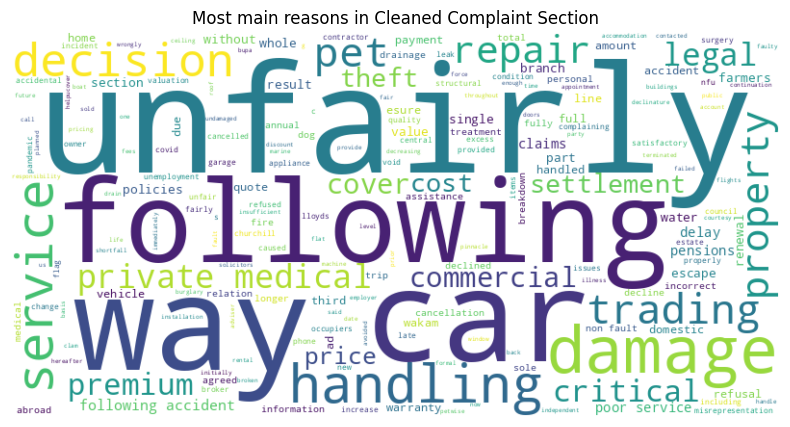

In [13]:
generate_word_cloud(' '.join(df['main_reason'].dropna()), 'Most main reasons in Cleaned Complaint Section')

#### Step 2b: Extract the complaint section plus what happened section

In [14]:
def extract_complaint_and_what_happened_section(text):
    # Define the patterns to locate the complaint and what happened sections
    complaint_pattern = re.compile(r'The complaint(.*?)What happened', re.DOTALL)
    what_happened_pattern = re.compile(r'What happened(.*?)(What I’ve decided – and why|My final decision|The investigator’s view|My provisional decision|Putting things right)', re.DOTALL)
    
    # Extract the complaint section
    complaint_match = complaint_pattern.search(text)
    complaint_section = complaint_match.group(1).strip() if complaint_match else ''

    # Extract the what happened section
    what_happened_match = what_happened_pattern.search(text)
    what_happened_section = what_happened_match.group(1).strip() if what_happened_match else ''
    
    # Combine the extracted sections into one string
    combined_section = complaint_section + ' ' + what_happened_section
    return combined_section

# Apply the function to extract combined sections and add it as a new column
df['complaint_and_what_happened'] = df['original_text'].apply(extract_complaint_and_what_happened_section)
#generate_word_cloud(' '.join(df['complaint_and_what_happened'].dropna()), 'Most Common Words in Original text in complaint & what happened section')

#### Step 3: Investigate the most common words by the word cloud, cleaning the extracted text from Step 2a and 2b

In [128]:
# Clean the extracted sections
df['clean_2'] = df['complaint_and_what_happened'].apply(lambda x: remove_company_names(x, company_names) if x else None)

#generate_word_cloud(' '.join(df['clean_complain_n_what_happen'].dropna()), 'Most Common Words in cleaned complaint and what happened section')

df['cleaned_text'] = df['clean_2'].apply(lambda x: clean_text_with_synonyms(x, synonym_mapping, text_exclude) if x else None)
#generate_word_cloud(' '.join(df['cleaned_text'].dropna()), 'Most Common Words after cleaning and remove company names in complaint and what happened section')

In [125]:
df['cleaned_text'][0]

'about claim made on legal expenses policy , declined . treated unfairly wants to fund legal costs incurred at own expense to help resolve legal problem . in decision , to their claims handlers . made claim on legal expenses policy for cover to help boundary dispute on driveway . \n  accepted claim in firm instance passed to firm of solicitors to . solicitor considered claim determined n’t reasonable prospects of success based on evidence presently , required by policy . pointed out policy n’t in any event provide cover for defending claims in relation to property disputes against policyholders , to cover for . result , refused to fund claim . n’t assessment carried out n’t solicitor appointed independent . type of claim to make covered by policy . \n  considered upheld in part . n’t accept policy extended to covering type of claim wanted to make for same reasons out by solicitor ’d instructed , identified service failing in delay between claim being made accepted of 13 days , caused f

#### Adding decision and company columns to the DataFrame

In [17]:
# Adding decision and company columns to the DataFrame
def add_decision_and_company_info(df, metadata):
    decisions = []
    companies = []
    for filename in df['filename']:
        decision, company = get_metadata_info(filename)
        decisions.append(decision)
        companies.append(standardize_company_name(company))
    
    df['decision'] = decisions
    df['company'] = companies

    # Remove blank brackets () from company names
    df['company'] = df['company'].str.replace(r'\(\s*\)', '', regex=True).str.strip()

    return df

# Apply the function to add decision and company info to the DataFrame
df = add_decision_and_company_info(df, metadata)

### Extract Product Type

In [18]:
# Known product types for insurance
known_products = {
    'property': r'(property owners|property insurance|home insurance|home emergency|land|house)',
    'buildings': r'(buildings|buildings and contents|flat|apartment)',
    'machine and electronics': r'(appliances|washing machine)',
    'car': r'(car insurance|motor|vehicle)',
    'travel': r'(travel|trip)',
    'health': r'(health|healthcare|disease|medical|private medical|surgery|hospital)',
    'life': r'(life|life insurance|life policy|life protection)',
    'pet': r'(pet|dog|petwise|animal)',
    'business': r'(business insurance|business interruption|business)', 
    'income': r'(income|income protection|income insurance)',
    'boiler': r'boiler',
    'wedding': r'(wedding|wedding insurance)',
    'emergency': r'(emergency insurance|emergency protection|emergency warranty)',
    'legal expenses': r'(legal advice|legal expenses|legal expense)',
    'ppi' : r'(payment protection insurance|ppi)',
    'others':r'(home|property|burglary)',
}

# Function to extract product type from text
def extract_product_type(text):
    product_types = set()

    # Check for known product types first
    for product, pattern in known_products.items():
        if re.search(pattern, text, re.IGNORECASE):
            product_types.add(product)

    # If multiple product types are detected, return the first match for simplicity
    if len(product_types) > 1:
        product_types = {list(product_types)[0]}
    
    return ', '.join(product_types) if product_types else 'Unknown'

# Example synonym mapping
synonym_mapping = {
    "insurance": "insurance",
    "warranty": "insurance",
    "guarantee": "insurance",
}

# Exclusion set for cleaning text
exclude = set(["claim", "policy", "complain", "complains",  "complaint", "complained", "company", "brokers", "decline", "reference",
               "period", "cover", "follow", "service"])

df['clean_complaint'] = df['complaint_section'].apply(lambda x: clean_text_with_synonyms(x, synonym_mapping, exclude))
# Apply the extract_product_type function to the DataFrame
df['product_type'] = df['clean_complaint'].apply(extract_product_type)

# Define a function to re-extract product type from cleaned text if initial extraction is 'Unknown'
def re_extract_product_type(row):
    if row['product_type'] == 'Unknown':
        return extract_product_type(row['cleaned_text'])
    return row['product_type']

# Apply the re-extraction function
df['product_type'] = df.apply(re_extract_product_type, axis=1)

# Count occurrences of each product type
product_type_counts = df['product_type'].value_counts()

# Display the counts
print(product_type_counts)

product_type
car                        117
others                      96
travel                      37
life                        25
health                      19
pet                         16
buildings                   15
Unknown                     14
legal expenses              10
property                     9
income                       4
business                     3
ppi                          3
boiler                       2
machine and electronics      2
Name: count, dtype: int64


In [19]:
df.head()

,filename,original_text,complaint_section,main_reason,complaint_and_what_happened,clean_2,cleaned_text,decision,company,clean_complaint,product_type
0,05_24_Insurance_DRN-4742637.pdf,DRN-4742637\nThe complaint\nMrs K’s complaint ...,The complaint\nMrs K’s complaint is about a cl...,is she on her legal,Mrs K’s complaint is about a claim she made on...,Mrs K’s complaint is about a claim she made on...,about claim made on her legal expenses policy ...,Not upheld,One,the is about she made on her one insurance lim...,legal expenses
1,05_24_Insurance_DRN-4799770.pdf,"DRN-4799770\nThe complaint\nMr R, Mrs W and Mi...","The complaint\nMr R, Mrs W and Miss W complain...",ad handling of their,"Mr R, Mrs W and Miss W complain about Euroins ...","Mr R, Mrs W and Miss W complain about AD’s ha...",", about ad ’s handling of their travel claim ....",Not upheld,Euroins AD,"the , and about euroins ad ’s handling of thei...",travel
2,05_24_Insurance_DRN-4765620.pdf,DRN-4765620\nThe complaint\nMr E complains Her...,The complaint\nMr E complains Herts Insurance ...,trading unfairly his after payment on agreed date,Mr E complains Herts Insurance Consultants Ltd...,Mr E complains Herts Insurance Consultants Ltd...,herts consultants trading as sterling services...,Not upheld,Herts Consultants,the herts insurance consultants ltd trading as...,car
3,05_24_Insurance_DRN-4676443.pdf,DRN-4676443\nThe complaint\nMr and Mrs S’ comp...,The complaint\nMr and Mrs S’ complaint is abou...,is handling of they on their,Mr and Mrs S’ complaint is about the handling ...,Mr and Mrs S’ complaint is about the handling ...,about handling of claim made on their das lega...,Not upheld,DAS Legal Expenses,the and is about the handling of they made on ...,legal expenses
4,05_24_Insurance_DRN-4745742.pdf,DRN-4745742\nThe complaint\nMiss T complains t...,The complaint\nMiss T complains that Advantage...,for damage she it on her discount under her,Miss T complains that Advantage Insurance Comp...,Miss T complains that Insurance Company Limit...,progressed claim for vandalism damage after ’d...,Upheld,Advantage,the that advantage insurance limited advantage...,car


### Splitting Data Into Training and Testing  

In [129]:
# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [130]:
# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Encode text function
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Compute embeddings for all cleaned text in the DataFrame
def compute_embeddings(df, column_name):
    embeddings = df[column_name].apply(encode_text)
    return np.vstack(embeddings)

# Assuming train_df and test_df are your training and testing dataframes
X_train = compute_embeddings(train_df, 'cleaned_text')
X_test = compute_embeddings(test_df, 'cleaned_text')

In [24]:
"""
# Load the paraphrase-mpnet-base-v2 model 'paraphrase-mpnet-base-v2'
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings
emb_train = model.encode(train_df['cleaned_text'].tolist(), convert_to_tensor=True)

# Optional: Convert embeddings to numpy array for further processing
emb_train_np = emb_train.cpu().numpy()

# Example: Printing the shape of the embeddings to verify
print(emb_train_np.shape)

# Save the embeddings to a .npy file
np.save('embed_train_0524.npy', emb_train_np)
# Generate embeddings for test data
emb_test = model.encode(test_df['cleaned_text'].tolist(), convert_to_tensor=True)

# Optional: Convert embeddings to numpy array for further processing
emb_test_np = emb_test.cpu().numpy()

# Example: Printing the shape of the embeddings to verify
print(emb_test_np.shape)

# Save the embeddings to a .npy file
np.save('embed__test_0524.npy', emb_test_np)
"""

"\n# Load the paraphrase-mpnet-base-v2 model 'paraphrase-mpnet-base-v2'\nmodel = SentenceTransformer('all-mpnet-base-v2')\n\n# Generate embeddings\nemb_train = model.encode(train_df['cleaned_text'].tolist(), convert_to_tensor=True)\n\n# Optional: Convert embeddings to numpy array for further processing\nemb_train_np = emb_train.cpu().numpy()\n\n# Example: Printing the shape of the embeddings to verify\nprint(emb_train_np.shape)\n\n# Save the embeddings to a .npy file\nnp.save('embed_train_0524.npy', emb_train_np)\n# Generate embeddings for test data\nemb_test = model.encode(test_df['cleaned_text'].tolist(), convert_to_tensor=True)\n\n# Optional: Convert embeddings to numpy array for further processing\nemb_test_np = emb_test.cpu().numpy()\n\n# Example: Printing the shape of the embeddings to verify\nprint(emb_test_np.shape)\n\n# Save the embeddings to a .npy file\nnp.save('embed__test_0524.npy', emb_test_np)\n"

In [25]:

# Load the embeddings from the .npy file
# embeddings_numpy = np.load('embed_vectors.npy')

In [131]:
y_train = train_df['decision']
y_test = test_df['decision']

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape : {X_train.shape}')
print(f'X_test shape :{X_test.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'y_test shape : {y_test.shape}')

X_train shape : (297, 768)
X_test shape :(75, 768)
y_train shape : (297,)
y_test shape : (75,)


### Explore y_train and X_train

Label distribution in training data:
 decision
Not upheld    158
Upheld        139
Name: count, dtype: int64


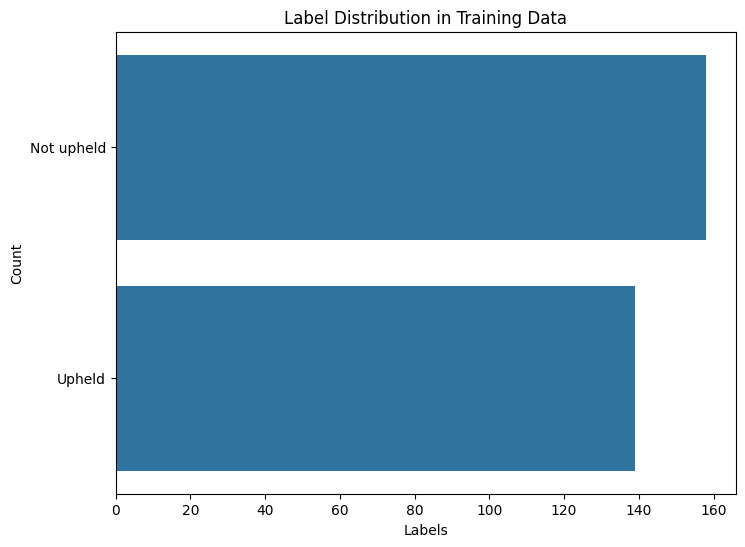

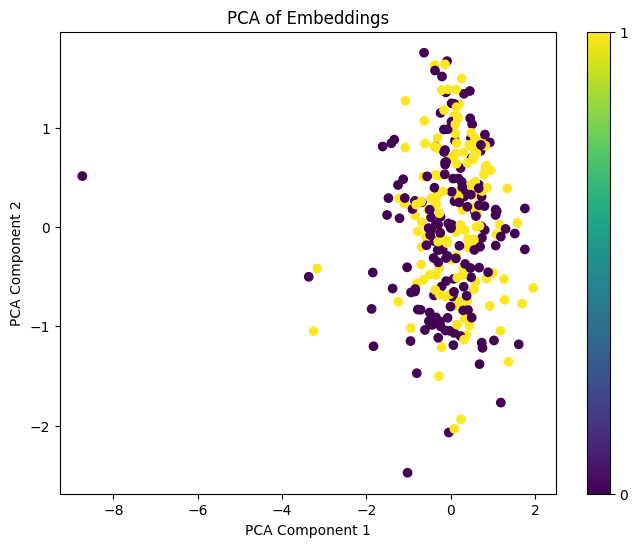

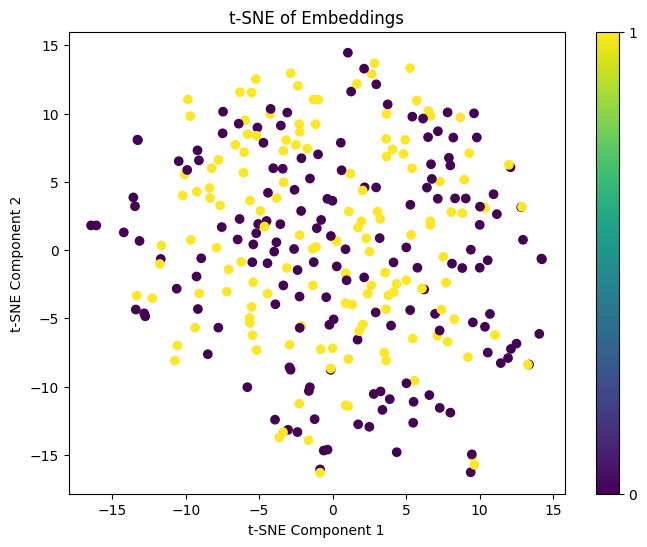

Missing values in X_train: 0
Missing values in y_train: 0


In [132]:
# Encode the labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# 1. Check the distribution of the labels
label_counts = y_train.value_counts()
print("Label distribution in training data:\n", label_counts)

# Plot the label distribution
plt.figure(figsize=(8, 6))
sns.countplot(y_train)
plt.title("Label Distribution in Training Data")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

# 2. Visualize the embedding distributions
# PCA for 2D visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='viridis')
plt.colorbar(scatter, ticks=range(len(label_counts)))
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# t-SNE for 2D visualization (this can take some time)
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_encoded, cmap='viridis')
plt.colorbar(scatter, ticks=range(len(label_counts)))
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# 3. Check for missing values
missing_values_X_train = np.sum(np.isnan(X_train))
missing_values_y_train = np.sum(pd.isnull(y_train))
print(f"Missing values in X_train: {missing_values_X_train}")
print(f"Missing values in y_train: {missing_values_y_train}")

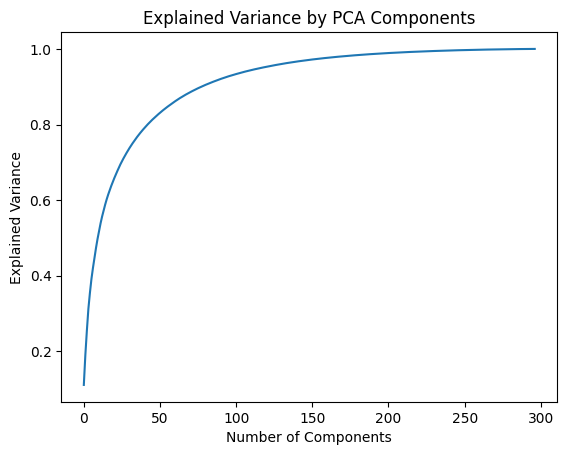

In [133]:
pca = PCA()
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [134]:
"""
from sklearn.decomposition import PCA

# Let's assume we want to capture 95% of the variance
pca = PCA(n_components=0.95)  # 0.95 means we want 95% variance
X_train_OptDim = pca.fit_transform(X_train)

# Transform the test set as well
X_test_OptDim = pca.transform(X_test)

# Check the shape of the reduced data
print(f"Reduced X_train shape: {X_train_OptDim.shape}")
print(f"Reduced X_test shape: {X_test_OptDim.shape}")
"""


'\nfrom sklearn.decomposition import PCA\n\n# Let\'s assume we want to capture 95% of the variance\npca = PCA(n_components=0.95)  # 0.95 means we want 95% variance\nX_train_OptDim = pca.fit_transform(X_train)\n\n# Transform the test set as well\nX_test_OptDim = pca.transform(X_test)\n\n# Check the shape of the reduced data\nprint(f"Reduced X_train shape: {X_train_OptDim.shape}")\nprint(f"Reduced X_test shape: {X_test_OptDim.shape}")\n'

### Modelling : Logistic Regression

In [135]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {'C': [5, 7, 10, 12, 15, 20], 'max_iter' : [10, 15, 20, 25, 30]}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, refit=True, verbose=2)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...................................C=5, max_iter=10; total time=   0.0s
[CV] END ...................................C=5, max_iter=10; total time=   0.0s
[CV] END ...................................C=5, max_iter=10; total time=   0.0s
[CV] END ...................................C=5, max_iter=10; total time=   0.0s
[CV] END ...................................C=5, max_iter=10; total time=   0.0s
[CV] END ...................................C=5, max_iter=15; total time=   0.0s
[CV] END ...................................C=5, max_iter=15; total time=   0.0s
[CV] END ...................................C=5, max_iter=15; total time=   0.0s
[CV] END ...................................C=5, max_iter=15; total time=   0.0s
[CV] END ...................................C=5, max_iter=15; total time=   0.0s
[CV] END ...................................C=5, max_iter=20; total time=   0.0s
[CV] END ...................................C=5

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ...................................C=5, max_iter=30; total time=   0.0s
[CV] END ...................................C=5, max_iter=30; total time=   0.0s
[CV] END ...................................C=5, max_iter=30; total time=   0.0s
[CV] END ...................................C=5, max_iter=30; total time=   0.0s
[CV] END ...................................C=5, max_iter=30; total time=   0.0s
[CV] END ...................................C=7, max_iter=10; total time=   0.0s
[CV] END ...................................C=7, max_iter=10; total time=   0.0s
[CV] END ...................................C=7, max_iter=10; total time=   0.0s
[CV] END ...................................C=7, max_iter=10; total time=   0.0s
[CV] END ...................................C=7, max_iter=10; total time=   0.0s
[CV] END ...................................C=7, max_iter=15; total time=   0.0s
[CV] END ...................................C=7, max_iter=15; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ...................................C=7, max_iter=25; total time=   0.0s
[CV] END ...................................C=7, max_iter=25; total time=   0.0s
[CV] END ...................................C=7, max_iter=25; total time=   0.0s
[CV] END ...................................C=7, max_iter=25; total time=   0.0s
[CV] END ...................................C=7, max_iter=30; total time=   0.0s
[CV] END ...................................C=7, max_iter=30; total time=   0.0s
[CV] END ...................................C=7, max_iter=30; total time=   0.0s
[CV] END ...................................C=7, max_iter=30; total time=   0.0s
[CV] END ...................................C=7, max_iter=30; total time=   0.0s
[CV] END ..................................C=10, max_iter=10; total time=   0.0s
[CV] END ..................................C=10, max_iter=10; total time=   0.0s
[CV] END ..................................C=10, max_iter=10; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ..................................C=10, max_iter=20; total time=   0.0s
[CV] END ..................................C=10, max_iter=25; total time=   0.0s
[CV] END ..................................C=10, max_iter=25; total time=   0.0s
[CV] END ..................................C=10, max_iter=25; total time=   0.0s
[CV] END ..................................C=10, max_iter=25; total time=   0.0s
[CV] END ..................................C=10, max_iter=25; total time=   0.0s
[CV] END ..................................C=10, max_iter=30; total time=   0.0s
[CV] END ..................................C=10, max_iter=30; total time=   0.0s
[CV] END ..................................C=10, max_iter=30; total time=   0.0s
[CV] END ..................................C=10, max_iter=30; total time=   0.0s
[CV] END ..................................C=10, max_iter=30; total time=   0.0s
[CV] END ..................................C=12, max_iter=10; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ..................................C=12, max_iter=15; total time=   0.0s
[CV] END ..................................C=12, max_iter=15; total time=   0.0s
[CV] END ..................................C=12, max_iter=15; total time=   0.0s
[CV] END ..................................C=12, max_iter=20; total time=   0.0s
[CV] END ..................................C=12, max_iter=20; total time=   0.0s
[CV] END ..................................C=12, max_iter=20; total time=   0.0s
[CV] END ..................................C=12, max_iter=20; total time=   0.0s
[CV] END ..................................C=12, max_iter=20; total time=   0.0s
[CV] END ..................................C=12, max_iter=25; total time=   0.0s
[CV] END ..................................C=12, max_iter=25; total time=   0.0s
[CV] END ..................................C=12, max_iter=25; total time=   0.0s
[CV] END ..................................C=12, max_iter=25; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ..................................C=12, max_iter=30; total time=   0.0s
[CV] END ..................................C=15, max_iter=10; total time=   0.0s
[CV] END ..................................C=15, max_iter=10; total time=   0.0s
[CV] END ..................................C=15, max_iter=10; total time=   0.0s
[CV] END ..................................C=15, max_iter=10; total time=   0.0s
[CV] END ..................................C=15, max_iter=10; total time=   0.0s
[CV] END ..................................C=15, max_iter=15; total time=   0.0s
[CV] END ..................................C=15, max_iter=15; total time=   0.0s
[CV] END ..................................C=15, max_iter=15; total time=   0.0s
[CV] END ..................................C=15, max_iter=15; total time=   0.0s
[CV] END ..................................C=15, max_iter=15; total time=   0.0s
[CV] END ..................................C=15, max_iter=20; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ..................................C=15, max_iter=25; total time=   0.0s
[CV] END ..................................C=15, max_iter=25; total time=   0.0s
[CV] END ..................................C=15, max_iter=25; total time=   0.0s
[CV] END ..................................C=15, max_iter=25; total time=   0.0s
[CV] END ..................................C=15, max_iter=25; total time=   0.0s
[CV] END ..................................C=15, max_iter=30; total time=   0.0s
[CV] END ..................................C=15, max_iter=30; total time=   0.0s
[CV] END ..................................C=15, max_iter=30; total time=   0.0s
[CV] END ..................................C=15, max_iter=30; total time=   0.0s
[CV] END ..................................C=15, max_iter=30; total time=   0.0s
[CV] END ..................................C=20, max_iter=10; total time=   0.0s
[CV] END ..................................C=20, max_iter=10; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [5, 7, 10, 12, 15, 20],
                         'max_iter': [10, 15, 20, 25, 30]},
             verbose=2)

In [136]:
# Best parameters from GridSearchCV for Logistic Regression
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

# Predictions and evaluation for Logistic Regression
y_pred_lr = grid_lr.predict(X_test)
print("Logistic Regression Classifier:")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Best parameters for Logistic Regression: {'C': 10, 'max_iter': 15}
Logistic Regression Classifier:
              precision    recall  f1-score   support

  Not upheld       0.59      0.64      0.61        36
      Upheld       0.64      0.59      0.61        39

    accuracy                           0.61        75
   macro avg       0.61      0.61      0.61        75
weighted avg       0.62      0.61      0.61        75

[[23 13]
 [16 23]]


### Modelling : Decision Tree

In [137]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 8, 10, 12, 15], 'min_samples_split': [2 ,3, 4, 5, 6]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, refit=True, verbose=2)
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...criterion=gini, max_depth=5, min_samples_split=2; total time=   0.2s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=2; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=2; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=2; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=2; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=3; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=3; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=3; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=3; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=3; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_samples_split=4; total time=   0.1s
[CV] END ...criterion=gini, max_depth=5, min_sa

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 10, 12, 15],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             verbose=2)

In [138]:
# Best parameters from GridSearchCV for Decision Tree
print("Best parameters for Decision Tree:", grid_dt.best_params_)

# Predictions and evaluation for Decision Tree
y_pred_dt = grid_dt.predict(X_test)
print("Decision Tree Classifier:")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 3}
Decision Tree Classifier:
              precision    recall  f1-score   support

  Not upheld       0.55      0.61      0.58        36
      Upheld       0.60      0.54      0.57        39

    accuracy                           0.57        75
   macro avg       0.57      0.57      0.57        75
weighted avg       0.58      0.57      0.57        75

[[22 14]
 [18 21]]


### Modeling : Random Forest

In [139]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [100, 250, 350, 400, 450], 'max_features': ['auto', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=350; total time=   0.0s
[CV] END ................max_features=auto, n_es

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/c

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'log2'],
                         'n_estimators': [100, 250, 350, 400, 450]},
             verbose=2)

In [140]:
# Best parameters from GridSearchCV for Random Forest
best_rf = grid_rf.best_estimator_
print("Best parameters for Random Forest:", best_rf)

# Predictions and evaluation for Random Forest
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Best parameters for Random Forest: RandomForestClassifier(max_features='log2', n_estimators=450)
Random Forest Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.66      0.81      0.72        36
      Upheld       0.77      0.62      0.69        39

    accuracy                           0.71        75
   macro avg       0.72      0.71      0.71        75
weighted avg       0.72      0.71      0.70        75

[[29  7]
 [15 24]]


### Feature Importance

Feature Importance:
 [0.00205118 0.00110807 0.00185417 0.00088456 0.00120211 0.001044
 0.00123742 0.00486111 0.00090709 0.00111903 0.00170855 0.00160734
 0.00173357 0.00146942 0.0013938  0.00101788 0.0012088  0.00099312
 0.00227345 0.00060083 0.00288795 0.00053763 0.0007319  0.00082253
 0.00107138 0.00083778 0.00087255 0.00174695 0.00092836 0.00123547
 0.00105155 0.00076706 0.00132031 0.00129175 0.00128197 0.00127612
 0.00080461 0.0015751  0.00094953 0.00076208 0.00277144 0.00107438
 0.00124062 0.00196497 0.00109305 0.0013254  0.00191724 0.0015619
 0.00164548 0.00101768 0.00119718 0.00146645 0.00103602 0.00236734
 0.00132174 0.00102861 0.00160164 0.00079728 0.00098411 0.00120868
 0.00234366 0.00073621 0.00067822 0.00126633 0.00126374 0.00229679
 0.0007725  0.00072671 0.00134915 0.00150288 0.00195465 0.00095425
 0.00127462 0.00092516 0.00119221 0.00115914 0.00157394 0.00110857
 0.00098061 0.00091226 0.00132738 0.00134406 0.00191414 0.0030428
 0.00149565 0.00306604 0.00088372 0.00177532 

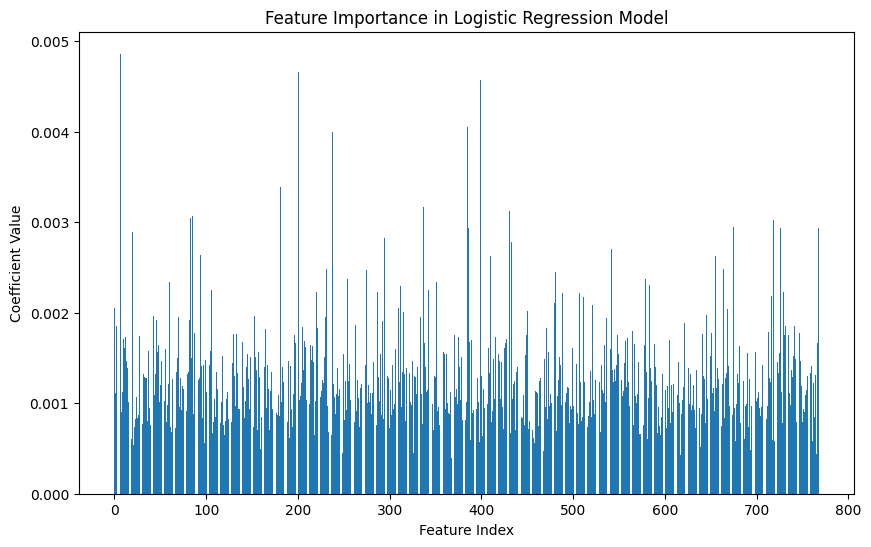

In [141]:
# Get the coefficients from the trained model
#best_lr = grid_lr.best_estimator_
feature_importance = best_rf.feature_importances_

# Print the feature importance
print("Feature Importance:\n", feature_importance)

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance in Logistic Regression Model")
plt.show()

In [162]:
# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Encode text function
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Extract the original sentence from df for the first test instance
sentence = test_df['cleaned_text'].iloc[0]
print("Original Sentence:", sentence)

# Segment the sentence into words
segments = sentence.split()

# Compute embeddings for the sentence segments using BERT
segment_embeddings = np.array([encode_text(segment)[0] for segment in segments])
print("Segment Embeddings Shape:", segment_embeddings.shape)

# Assuming best_rf is your trained random forest model
# Generate SHAP values using TreeExplainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# First version: Using shap_values[first_test_index]
first_test_index = 0  # Assuming this is the index of the first test instance in the DataFrame
first_test_shap_values_v1 = shap_values[first_test_index]  # Use first obs in test data

# Second version: Using shap_values[first_test_index][1]
first_test_shap_values = first_test_shap_values_v1[:, 1]  # Use class 1 for binary classification

# Compute cosine similarity between the SHAP contribution vector and the segment embeddings
word_contributions = []
for word_embedding in segment_embeddings:
    word_shap_value = cosine_similarity(word_embedding.reshape(1, -1), first_test_shap_values.reshape(1, -1))[0][0]
    word_contributions.append(word_shap_value)

# Get the top contributing words based on their SHAP values
top_word_indices = np.argsort(-np.abs(word_contributions))[:50]
top_words = [segments[idx] for idx in top_word_indices]

# Preserve the original order of the top contributing words
top_words_in_order = [word for word in segments if word in top_words and segments.count(word) == 1]

# Reconstruct the sentence using only the top contributing words
top_sentence = ' '.join(top_words_in_order)
print("\nTop contributing sentence reconstructed from top contributing words:")
print(top_sentence)


Original Sentence: declined claim for lost mobile phone . ’s unhappy how handled claim . agents . took out mobile phone policy on 26 . provided cover if insured phone lost . lost phone in made claim on policy . policy n’t validated , but n’t . provided images of phone 
  within seven days of taking out policy . no correspondence from suggest him any outstanding information , policy n’t validated . payments for policy continued taken out month .  
 in trying deal spent of hours on phone , through someone put on hold around three different departments . for evidence tried contact him regarding validating policy but none provided . 
  if received information requested policy validated . evident n’t receive any information required validate policy . 
  confirmed payment taken for policy entered credit direct debit . n’t referred financial service . of into things for him .  
 fairly declined claim no evidence policy validated . cancelled policy returned premiums per terms of policy . recom

: 

In [160]:
import shap
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Encode text function
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Assuming best_rf is your trained random forest model
# Generate SHAP values using TreeExplainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# First version: Using shap_values[1][first_test_index]
first_test_index = 0  # Assuming this is the index of the first test instance in the DataFrame
first_test_shap_values_v1 = shap_values[first_test_index]  # Use first obs in test data

# Second version: Using shap_values[first_test_index][1]
first_test_shap_values = first_test_shap_values_v1[:, 1]  # Use class 1 for binary classification

# Extract the original sentence from df for the first test instance
sentence = test_df['cleaned_text'].iloc[first_test_index]
print("Original Sentence:", sentence)

# Segment the sentence into words
segments = sentence.split()

# Compute embeddings for the sentence segments using BERT
segment_embeddings = np.array([encode_text(segment)[0] for segment in segments])
print("Segment Embeddings Shape:", segment_embeddings.shape)

# Compute cosine similarity between the SHAP contribution vector and the segment embeddings
word_contributions = []
for word_embedding in segment_embeddings:
    word_shap_value = cosine_similarity(word_embedding.reshape(1, -1), first_test_shap_values.reshape(1, -1))[0][0]
    word_contributions.append(word_shap_value)

# Get the top contributing words based on their SHAP values
top_word_indices = np.argsort(-np.abs(word_contributions))[:40]
top_words = [segments[idx] for idx in top_word_indices]

# Preserve the original order of the top contributing words
top_words_in_order = [word for word in segments if word in top_words]

# Reconstruct the sentence using only the top contributing words
top_sentence = ' '.join(top_words_in_order)
print("\nTop contributing sentence reconstructed from top contributing words:")
print(top_sentence)


Original Sentence: declined claim for lost mobile phone . ’s unhappy how handled claim . agents . took out mobile phone policy on 26 . provided cover if insured phone lost . lost phone in made claim on policy . policy n’t validated , but n’t . provided images of phone 
  within seven days of taking out policy . no correspondence from suggest him any outstanding information , policy n’t validated . payments for policy continued taken out month .  
 in trying deal spent of hours on phone , through someone put on hold around three different departments . for evidence tried contact him regarding validating policy but none provided . 
  if received information requested policy validated . evident n’t receive any information required validate policy . 
  confirmed payment taken for policy entered credit direct debit . n’t referred financial service . of into things for him .  
 fairly declined claim no evidence policy validated . cancelled policy returned premiums per terms of policy . recom